## Introduction

This project provides various methods to solve the 1D Burgers equation:
$$
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}
$$
where $u(t, x)$ is the velocity field, $\nu$ is the kinematic viscosity, and $t$ and $x$ are time and space variables, respectively. The domain is defined as $t \in [0, T]$ and $x \in [-1, 1]$ with initial conditions $u(0, x) = -\sin(\pi x)$ and Dirichlet boundary conditions $u(-1,t)=u(1,t)=0$. We will only consider kinematic viscosity $\nu = 10^{-2}/\pi$.

The following methods are implemented:
1. Fourier spectral methods (Galerkin and pseudospectral)
2. Chebyshev-Tau spectral method with ABCN scheme
3. Finite difference method with BDF2 and coordinate transformation
4. Physics-informed neural network (PINNs)

The first three methods are inspired by the paper "Spectral and finite difference solutions of the Burgers equation" by Basdevant, C. et al. Comput. Fluids 14, 23 (1986). This paper will be referenced as Basdevant1986 in the following.

The project uses the Julia programming language as I've been wanting to learn it for a while.

Aside from reading this notebook, I encourage you to check out the code in the repository live on `https://github.com/octionary/BurgersJoint`. The code is organized into modules, each corresponding to a different method.

## Analytical solution

We use the convolution form from Cole's transformation like Basdevant1986. We assume initial conditions $u(x,0) = -\sin{(\pi x)}$. The solution is expressed as
$$u(x,t) = \frac{I_1(x,t)}{I_2(x,t)},$$
where
$$I_1(x,t) = -\int_{-\infty}^{+\infty} \sin(\pi(x-\eta))\, f(x-\eta) \exp\left(-\frac{\eta^2}{4 \nu t}\right)\, \mathrm{d}\eta,$$
$$I_2(x,t) = \int_{-\infty}^{+\infty} f(x-\eta) \exp\left(-\frac{\eta^2}{4 \nu t}\right)\, \mathrm{d}\eta,$$
$$f(y) = \exp{\left(-\frac{\cos{(\pi y})}{2\pi\nu}\right)}.$$
A change of variables $\eta = Sz$ with $S = \sqrt{4 \nu t}$ is used so that
$$d\eta = S \,\mathrm{d}z, \quad \exp\left(-\frac{\eta^2}{4\nu t}\right) = \exp(-z^2),$$
yielding
$$I_1(x,t) = -\int_{-\infty}^{+\infty} \sin(\pi(x-Sz)) f(x-Sz) \exp\left(-z^2\right)\, \mathrm{d}\eta,$$
$$I_2(x,t) = \int_{-\infty}^{+\infty} f(x-Sz) \exp\left(-z^2\right)\, \mathrm{d}\eta,$$
Gauss-Hermite quadrature (with $n$ nodes) can now be used to evaluate these integrals:
$$I_1(x,t) \approx \sum_{i=1}^n w_i \sin(\pi(x-Sz_i))\, f(x-Sz_i)$$
$$I_2(x,t) \approx \sum_{i=1}^n w_i f(x-Sz_i)$$
Here, $z_i$ are the roots of the Hermite polynomial are the corresponding weights $w_i$. I use Julia package *FastGaussQuadrature* to provide the $z_i$ and $w_i$.



# 2. Fourier spectral
This notebook demonstrates solving the 1D Burgers Equation using the Fourier Galerkin and Fourier pseudospectral methods implemented based on Basdevant1986.

We'll go over the following:
- How I apply Fourier spectral methods to the 1D Burgers equation
- Some example results from my implementation

A more thorough study of the performance is saved for the comparison between methods.


In [20]:
using Pkg
Pkg.activate("..") # activate BurgersJoint environment
Pkg.instantiate() # install all dependencies if necessary
using BurgersJoint
using BurgersJoint.BurgersEquation
using BurgersJoint.FourierSpectral
using Plots

  Activating project at `~/Documents/ACFPD/Individual assignment/BurgersJoint`


## Fourier spectral methods for the 1D Burgers equation
The 1D Burgers equation is given by
$$
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}
$$
where $u$ is the velocity field, $\nu$ is the kinematic viscosity, and $x$ is the spatial coordinate. We consider this problem defined for $t \in [0, T]$ and $x \in [-1, 1]$ with initial condition $u(0, x) = -\sin(\pi x)$ and periodic boundary conditions. The Fourier spectral method approximates the solution using a Fourier series expansion in space, such as:
$$
u(x, t) = \sum_{j=-N/2 + 1}^{N/2} \hat{u}_k(t) e^{i k_j x},\quad k_j = \frac{2 \pi j}{L}
$$
where $\hat{u}_k(t)$ are the Fourier coefficients, $N$ is the number of grid points (assumed even for this example), and $\left\{k_j\right\}$ are the angular wavenumbers. This form is inherently periodic, which is a requirement for the Fourier spectral method. As for this project we are considering a periodic problem, we can use the Fourier spectral methods. The Fourier coefficients can be computed using the Fast Fourier Transform (FFT) algorithm, where they are given by:
$$
\hat{u}_k(t) = \sum_{j=-N/2 + 1}^{N/2} u_j(t) e^{-i k x_j},\quad x_j = \frac{L j}{N}
$$
This expansion of the solution allows us to perform time integration in the Fourier space, which is often more efficient than in real space, especially for nonlinear problems like the Burgers equation. To see why, let us first apply a Fourier transform to the PDE.

### Solution of Burgers' equation in Fourier space
Relevant derivatives are:
$$
\mathcal{F}\big[u(x,t)\big] = \hat{u}(k,t),\quad \mathcal{F}\big[\partial_t u\big] = \partial_t \hat{u},\quad \mathcal{F}\big[\partial_x u\big] = i\,k\,\hat{u},\quad \mathcal{F}\big[\partial_x^2 u\big] = -k^2\,\hat{u},
$$
$$
\mathcal{F}\!\left[u\,\partial_x u\right] = \mathcal{F}\!\left[\frac{1}{2} \partial_x u^2\right] = \frac{ik}{2} \mathcal{F}\!\left[u^2\right]\,.
$$
Burgers' equation reads

$$
\partial_t u + u\,\partial_x u = \nu\,\partial_x^2 u\,.
$$

Taking the Fourier transform term‐by‐term, we obtain

$$
\partial_t \hat{u}(k,t) + \frac{ik}{2} \mathcal{F}\!\left[u^2\right](k,t) = -\nu\,k^2\,\hat{u}(k,t)\,.
$$

We cannot further simplify this equation, as the term $\mathcal{F}\!\left[u^2\right]$ is not known. We can however solve the equation numerically by using the Fourier pseudospectral method and evaluating the term $\mathcal{F}\!\left[u^2\right]$ in real space. We can do this by first finding the real space solution $u(x,t)$ from the Fourier coefficients $\hat{u}(k,t)$, then evaluating $u^2(x,t)$ in real space, and finally taking the Fourier transform of $u^2(x,t)$ to find $\mathcal{F}\!\left[u^2\right]$.

### Numerical time-stepping scheme

To solve the equation numerically, we can use a time-stepping scheme. For the first half-step we'll use a first-order (Euler) approximation, which updates the solution as follows:
$$
\hat{u}(k,t+\Delta t) = e^{-\nu k^2 \Delta t} \hat{u}(k,t) - \Delta t e^{-\nu k^2 \Delta t} \frac{ik}{2} \mathcal{F}\!\left[u^2\right](k,t) = e^{-\nu k^2 \Delta t} \left[\hat{u}(k,t) - \Delta t\ \frac{ik}{2} \mathcal{F}\!\left[u^2\right](k,t)\right]\,.
$$
For subsequent half-steps, we use the Leapfrog-like scheme from Basdevant1986:
$$
\hat{u}(k,t+\Delta t) = e^{-2\nu k^2 \Delta t} \hat{u}(k,t-\Delta t) - 2\Delta t e^{-\nu k^2 \Delta t} \frac{ik}{2}  \mathcal{F}\!\left[u^2\right](k,t)\,.
$$
This scheme should be second-order accurate in time and unconditionally stable for the viscous terms.

### Galerkin vs. pseudospectral

The Fourier expansion terms for $k_j=2 \pi j/L$ with $|j|\geq N/3$ introduce aliasing errors. Truncating the Fourier series to $|j| < N/3$ to avoid aliasing error and using the remaining terms to approximate the solution is called the Galerkin method. The Fourier pseudospectral method, on the other hand, uses all Fourier modes, leading to aliasing error.

To be consistent with Basdevant, we introduce the dealiasing factor $\alpha$ as
$$
\alpha = j_\mathrm{cut} / j_\mathrm{max} = 2/3,
$$ 
where $j_\mathrm{cut}$ is the cutoff wavenumber and $j_\mathrm{max}$ is the maximum wavenumber ($N/2$ for even $N$). The dealiasing factor is used to truncate the Fourier series to avoid aliasing errors. The Fourier coefficients are then given by:
$$
\hat{u}_k(t) = \begin{cases}
\hat{u}_k(t) & \text{if } |k| < \alpha N/2\\
0 & \text{if } |k| \geq \alpha N/2
\end{cases}
$$
For the Galerkin scheme, dealiasing is always done before evaluating the solution in real space from the Fourier coefficients.

### Summary of the algorithm

The algorithm for solving Burgers' equation with Fourier spectral methods is as follows:
1. Determine the initial real-space solution $u(x,0)$.
2. Perform DFT to find the initial Fourier coefficients $\hat{u}(k,0)$.
3. Time-stepping loop for $t = 0, \Delta t, \ldots, T$:
    1. Calculate $\mathcal{F}\!\left[u^2\right]$ from the real-space solution.
    2. Find $\hat{u}(k,t+\Delta t)$ from $\hat{u}(k,t)$ using the above update rule.
    3. Apply dealiasing to $\hat{u}(k,t+\Delta t)$ (only for the Galerkin method).
    4. Perform inverse DFT to find the real-space solution $u(x,t+\Delta t)$.

I invite you to check the implementation in `FourierSpectral.py` in the `src/methods` folder, where I explain the code in detail.

## Example results
Let us look at a few example solutions using the Fourier spectral methods. We will use the following parameters unless otherwise specified:
- Domain $x\in[-1,1]$
- Viscosity $\nu = 10^{-2}/\pi$
- Initial condition $u(x,0) = -\sin(x)$
- Number of grid points $N = 128$
- Time step $\Delta t = 0.001$
- Total time $T = 4/\pi$

#### Fourier Galerkin example

Set parameters and run solver:

In [21]:
# Parameter choices:
N   = 128
dt = 1e-3
T   = 4/pi
dt_snapshot = 1/pi # time between solution snapshots

x, u_final, snapshot_times, snapshots = solveFourierSpectral(N; dt=dt, T=T, dt_snapshot=dt_snapshot, dealias_factor=2/3)

(-0.984375:0.015625:1.0, [0.0005461620797875821, 0.028456810825054746, 0.030247340815682144, 0.029618666999834842, 0.05739175190628737, 0.06046690384676115, 0.05875724820521305, 0.08626858426361561, 0.09063713598729128, 0.08795325838203749  …  -0.09063713598729123, -0.08626858426361522, -0.058757248205212664, -0.06046690384676118, -0.0573917519062872, -0.02961866699983462, -0.030247340815682255, -0.0284568108250548, -0.0005461620797876376, -1.0815797607250623e-16], [0.0, 0.318, 0.637, 0.9550000000000001, 1.2730000000000001], [[0.049067674327418015, 0.0980171403295606, 0.14673047445536175, 0.19509032201612828, 0.2429801799032639, 0.2902846772544624, 0.33688985339222005, 0.3826834323650898, 0.4275550934302821, 0.47139673682599764  …  -0.4275550934302821, -0.3826834323650898, -0.33688985339222005, -0.2902846772544624, -0.2429801799032639, -0.19509032201612828, -0.14673047445536175, -0.0980171403295606, -0.049067674327418015, -0.0], [0.022800778537078487, 0.05059134174742441, 0.07360594390

Plot numerical solution versus analytical solution at different times:

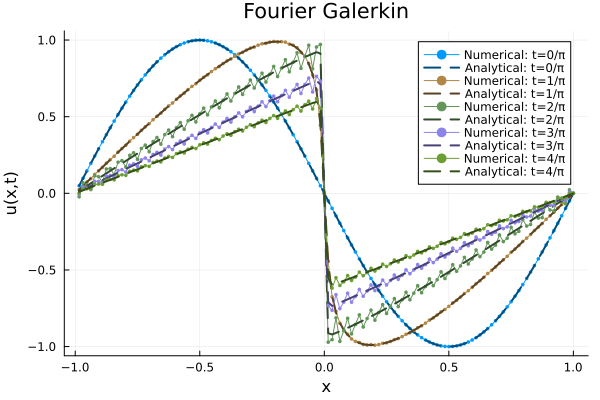

In [22]:
function plot_sol(method_name)
      plt = plot(title="$method_name", xlabel="x", ylabel="u(x,t)")
      pal = palette(:auto, length(snapshot_times))  # get default palette colors

      # Darken the analytical color by reducing brightness
      f = 0.5

      for (i, t) in enumerate(snapshot_times)
            num_color = pal[i]
            analytical_color = RGB(num_color.r * f, num_color.g * f, num_color.b * f)
            plot!(plt, x, snapshots[i], label="Numerical: t=$(i-1)/π", lw=1, color=num_color, marker=:circle, markersize=2, markerstrokewidth=0)
            plot!(plt, x, analytical_solution(x, t), label="Analytical: t=$(i-1)/π", lw=2, linestyle=:dash, color=analytical_color)
      end

      display(plt)
end

plot_sol("Fourier Galerkin")

We see that the numerical solution matches the analytical solution well, with oscillations due to the limited number of points used for the DFT. The oscillations are more pronounced around areas with large gradients, because Fourier basis functions are not well suited for representing discontinuous functions.

#### Fourier pseudospectral example

Same as above, but without dealiasing:

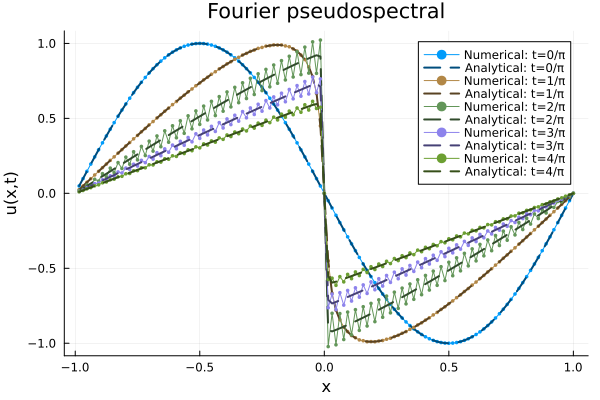

In [23]:
x, u_final, snapshot_times, snapshots = solveFourierSpectral(N; dt=dt, T=T, dt_snapshot=dt_snapshot, dealias_factor=1)
plot_sol("Fourier pseudospectral")

Higher-order oscillations are present in the solution, which is expected due to the aliasing errors introduced by using all Fourier modes.

#### Different grid spacings

A quick qualitative test of the effect of spatial and temporal grid spacings on the solution:

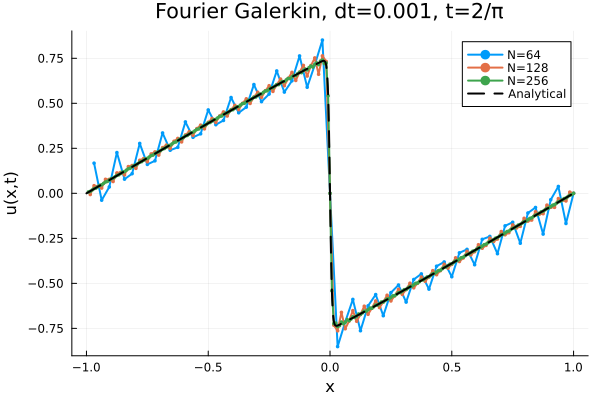

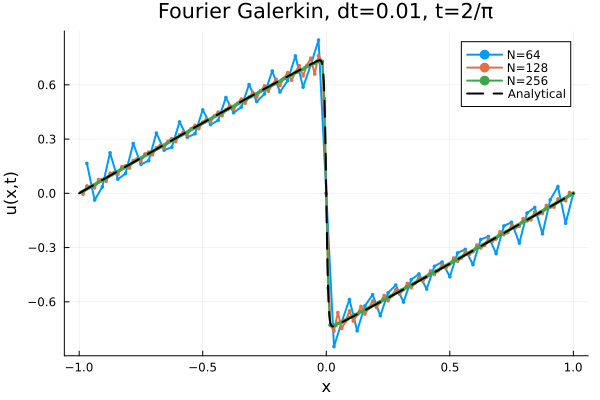

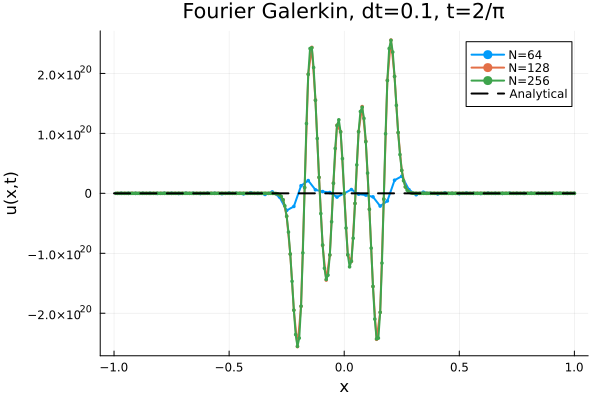

In [26]:
T = 3/pi
N_list = [64, 128, 256]
dt_list = [0.001, 0.01, 0.1]

for dt in dt_list
    plt = plot(title="Fourier Galerkin, dt=$dt, t=2/π", xlabel="x", ylabel="u(x,t)")
    for N in N_list
        x, u_final, _, _ = solveFourierSpectral(N; dt=dt, T=T, dealias_factor=(2)/3)
        plot!(plt, x, u_final, label="N=$N", lw=2, marker=:circle, markersize=2, markerstrokewidth=0)
    end
    x = range(-1, 1, length=1000)
    plot!(plt, x, analytical_solution(x, T), label="Analytical", lw=2, linestyle=:dash,color=:black)
    display(plt)
end

We see that the solution is more accurate for smaller spatial grid spacings (higher $N$), but oscillations are still present, albeit only at higher orders and smaller amplitudes. If the temporal grid spacing is too large, the solution becomes unstable and diverges.

# 3. Chebyshev-Tau spectral method
This notebook demonstrates solving the 1D Burgers equation using the Chebyshev-Tau spectral method, with implementation based on Basdevant1986 and the notes on spectral methods by Prof. Herman Clerx.

We'll go over the following:
- How I apply Chebyshev-Tau method to the 1D Burgers equation
- Some example results from my implementation

A more thorough study of the performance is saved for the comparison between methods.


In [23]:
using Pkg
Pkg.activate("..") # activate BurgersJoint environment
Pkg.instantiate() # install all dependencies if necessary
using BurgersJoint
using BurgersJoint.BurgersEquation
using BurgersJoint.ChebyshevTau
using Plots

  Activating project at `~/Documents/ACFPD/Individual assignment/BurgersJoint`


## Chebyshev-Tau method applied to the 1D Burgers equation

We again consider 1D Burgers equation:
$$
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2},
$$
defined for $t \in [0, T]$ and $x \in [-1, 1]$ with initial condition $u(0, x) = -\sin(\pi x)$ and periodic boundary conditions.

The velocity field $u(t, x)$ is approximated by a truncated Chebyshev series:
$$
u(t, x) = \sum_{j=0}^{N} a_j(t) T_n(x),
$$
where $a_j$ are the Chebyshev coefficients and $M=N+1$ is the number of Chebyshev modes. $T_n(x)$ are Chebyshev polynomials where we will use $j$ th order Chebyshev polynomials:
$$
T_n(x) = \cos(j \cos^{-1}(x)).
$$
where $x \in [-1, 1]$.
The spatial domain is discretized using Chebyshev-Gauss-Lobatto points
$$
x_j = \cos\left(\frac{j \pi}{N}\right), \quad j = 0, 1, \ldots, N,
$$
which are most closely spaced at the boundaries and least closely spaced in the middle of the domain:


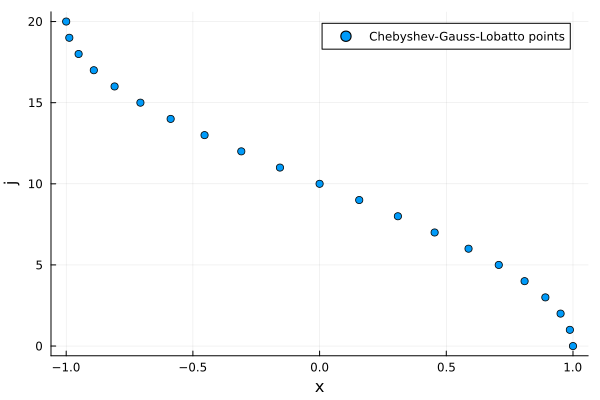

In [24]:
N = 20
j = 0:1:N
x = cos.(pi * (0:N) / N)
plot(x, j, seriestype = :scatter, 
    label = "Chebyshev-Gauss-Lobatto points", 
    xlabel = "x", 
    ylabel = "j")

Over this spatial grid, the velocity field can be written as a vector $\mathbf{u}(t)$ with elements $u_j=u(t, x_j)$ and the coefficients can be combined to a vector $\mathbf{a}(t)$ with elements $a_j(t)$:
$$
\mathbf{u}(t) = \begin{bmatrix}
u_0(t) \\ u_1(t) \\ \vdots \\ u_N(t)
\end{bmatrix},
\quad \mathbf{a}(t)=\begin{bmatrix}
a_0(t) \\ a_1(t) \\ \vdots \\ a_N(t)
\end{bmatrix}
$$
The Chebyshev approximation can then be written on the form
$$
\mathbf{u}(t) = \mathbf{V} \cdot \mathbf{a}(t),
$$
where $\mathbf{V}$ is the Chebyshev Vandermonde matrix:
$$
\mathbf{V} = \begin{bmatrix}
T_0(x_0) & T_1(x_0) & \cdots & T_N(x_0) \\
T_0(x_1) & T_1(x_1) & \cdots & T_N(x_1) \\
\vdots & \vdots & \ddots & \vdots \\
T_0(x_N) & T_1(x_N) & \cdots & T_N(x_N)
\end{bmatrix}
$$
As the Vandermonde matrix is invertible, we can find the Chebyshev coefficients from the inverse relation:
$$
\mathbf{a}(t) = \mathbf{V}^{-1} \mathbf{u}(t)
$$
Basdevant1986 shows that applying the Tau projection method to Burgers' equation leads to a system of ODEs for the Chebyshev coefficients:
$$
\mathbf{c} \odot \frac{d \mathbf{a}}{dt} = \mathbf{L} \cdot \mathbf{a}(t) - \mathbf{N}(t),
$$
where $\odot$ denote elementwise multiplication, $\mathrm{c}$ is a vector of weight factors, $\mathbf{L}$ is the linear operator and $\mathbf{N}$ is the nonlinear operator. Only the first $N-1$ elements should be considered on the left-hand side as the last two coefficients will be found from the following boundary conditions:
$$
\sum_{j=0}^{N} (-1)^j a_j(t) = 0,\quad \sum_{j=0}^{N} a_j(t) = 0.
$$
The weight factors are given by:
$$
\mathbf{c} = \begin{bmatrix}
2 \\ 1 \\ \vdots \\ 1
\end{bmatrix},
$$
The weight factors are used to ensure that the Chebyshev coefficients are normalized correctly.
The linear operator is a $(N-1)\times(N+1)$ matrix with elements (as per Basdevant1986):
$$
L_{lj} = \begin{cases}
\nu\, j\,(j^2 - l^2) & \text{if } j = l+2,\ j+l \text{ even},\\
0 & \text{otherwise}
\end{cases}
$$
The nonlinear term is simply the Chebyshev coefficients of the advection term $u\partial_x u$ of the Burgers equation:
$$
\mathbf{N}(t) = \mathbf{V}^{-1} \cdot \left(\mathbf{u}(t) \odot \frac{d \mathbf{u}}{dt}(t)\right)
$$
The time derivative of the velocity field, $\frac{d \mathbf{u}}{dt}(t)$, can be computed efficiently by:
$$
\frac{d \mathbf{u}}{dt}(t) = \mathbf{D} \cdot \mathbf{a}(t),
$$
where $\mathbf{D}$ is the Chebyshev differentiation matrix. The Chebyshev differentiation matrix is a square matrix of size $(N+1) \times (N+1)$. The elements of the Chebyshev differentiation matrix are given by (as per the Clerx note on spectral methods):
$$
D_{lj} = \begin{cases}
\frac{p_l}{p_j} \frac{(-1)^{l+j}}{x_l - x_j} & \text{if } l \neq j,\\
\frac{-x_j}{2(1-x_j^2)} & \text{if } l = j,\ l \neq 0,\ N,\\
\frac{2N^2+1}{6} & \text{if } l = 0,\ j = 0,\\
\frac{-2N^2+1}{6} & \text{if } l = N,\ j = N,\\
\end{cases}
$$
where $p_l$ and $p_j$ are elements of the weighting factor vector for differentiation:
$$
\mathbf{p} = \begin{bmatrix}
2 \\ 2 \\ 1 \\ \vdots \\ 1
\end{bmatrix},
$$


### ABCN method and its implementation

The ABCN scheme is a time-stepping scheme that is used to solve the system of ODEs for the Chebyshev coefficients. It uses the Adams-Bashforth (AB) for the nonlinear term and the Crank-Nicolson (CN) for the linear term. This scheme yields
$$
\frac{1}{\Delta t}\mathbf{c} \odot \left[\mathbf{a}(t+\Delta t) - \mathbf{a}(t) \right] = \mathcal{L}_\mathrm{CN}(t,t+\Delta t) - \mathcal{N}_\mathrm{AB}(t,t-\Delta t)
$$
Note that all terms here only include the first $N-1$ elements, as the last two should be given by the boundary conditions. I have omitted notating this explicitly as I haven't found a compact way of doing so. The Adam-Bashforth and Crank-Nicolson terms are defined as:
$$
\mathcal{N}_\mathrm{AB}(t,t-\Delta t) = \frac{3}{2}\mathbf{N}(t) - \frac{1}{2}\mathbf{N}(t-\Delta t),
$$
$$
\mathcal{L}_\mathrm{CN}(t,t+\Delta t) = \frac{1}{2}\left(\mathbf{L} \cdot \mathbf{a}(t) + \mathbf{L} \cdot \mathbf{a}(t+\Delta t)\right),
$$
To turn this into an update rule, we first rearrange to get all terms with $\mathbf{a}(t+\Delta t)$ on the left side:
$$
\left(\frac{1}{\Delta t}\mathbf{c}\cdot\mathbf{I} - \frac{1}{2}\mathbf{L}\right) \cdot \mathbf{a}(t+\Delta t) = \left(\frac{1}{\Delta t}\mathbf{c}\cdot\mathbf{I} + \frac{1}{2}\mathbf{L}\right) \cdot \mathbf{a}(t) - \mathcal{N}_\mathrm{AB}(t,t-\Delta t),
$$
we now introduce matric $\mathbf{A}$ and $\mathbf{B}$:
$$
\mathbf{A} = \frac{1}{\Delta t}\mathbf{c}\cdot\mathbf{I} - \frac{1}{2}\mathbf{L},\quad
\mathbf{B} = \frac{1}{\Delta t}\mathbf{c}\cdot\mathbf{I} + \frac{1}{2}\mathbf{L},
$$
so we can express $\mathbf{a}(t+\Delta t)$ by
$$
\mathbf{a}(t+\Delta t) = \mathbf{A}^{-1} \left[\mathbf{B} \cdot \mathbf{a}(t) - \mathcal{N}_\mathrm{AB}(t,t-\Delta t)\right],
$$
which we can make more compact by defining the right-hand side as $\mathbf{b}(t)$:
$$
\mathbf{b}(t) = \mathbf{B} \cdot \mathbf{a}(t) - \mathcal{N}_\mathrm{AB}(t,t-\Delta t),
$$
and the update rule becomes:
$$
\mathbf{a}(t+\Delta t) = \mathbf{A}^{-1} \cdot \mathbf{b}(t),
$$
Currently $\mathbf{b}$ is of size $N-1$ while $\mathbf{A}$ and $\mathbf{B}$ are of size $(N-1)\times(N+1)$ as this only gives us the first $N-1$ elements of $\mathbf{a}(t+\Delta t)$. . The last two elements are given by the boundary conditions (BCs) defined above. We can expand the system to include the BCs by extending $\mathbf{b}$ by two zeros representing the RHS of the BCs and adding two rows to $\mathbf{A}$ representing the sums in the BCs:
$$
\mathbf{b'} = \begin{bmatrix}
\mathbf{b} \\
0 \\ 0
\end{bmatrix},\quad
\mathbf{A'} = \begin{bmatrix}
A_{00} & A_{01} & A_{02} & \cdots & A_{0N} \\
A_{10} & A_{11} & A_{12} & \cdots & A_{1N} \\
\vdots & \vdots & \ddots & \vdots & \vdots \\
A_{N-1,0} & A_{N-1,1} & A_{N-1,2} & \cdots & A_{N-1,N} \\
1 & 1 & 1 & \cdots & 1 \\
1 & -1 & 1 & \cdots & (-1)^N
\end{bmatrix},
$$
With these, the whole system (all $N+1$ coefficients) can be time-stepped by:
$$
\mathbf{a}(t+\Delta t) = \mathbf{A'}^{-1} \cdot \mathbf{b'}.
$$
This is the final update rule for the Chebyshev-Tau method with the ABCN scheme.

### Summary of the algorithm

The algorithm for solving Burgers' equation using the Chebyshev-Tau method with the ABCN scheme can be summarized as follows:

1. Initialize the Chebyshev coefficients $\mathbf{a}(0)$ from the initial condition.
4. Compute the Chebyshev Vandermonde matrix $\mathbf{V}$.
2. Compute the Chebyshev differentiation matrix $\mathbf{D}$ and the linear operator $\mathbf{L}$.
3. Set up weight factors $\mathbf{c}$ and $\mathbf{p}$.
5. Set up matrices $\mathbf{A'}$ and $\mathbf{B}$.
6. Time-stepping loop
    1. Calculate Adams-Bashforth term $\mathcal{N}_\mathrm{AB}(t,t-\Delta t)$ using the Chebyshev coefficients of the velocity field:
        $$
        \mathcal{N}_\mathrm{AB}(t,t-\Delta t) = \frac{3}{2}\mathbf{N}(t) - \frac{1}{2}\mathbf{N}(t-\Delta t),
        $$
        where $\mathbf{N}(t)$ is computed using the Chebyshev coefficients of the velocity field.
    2. Find $\mathbf{b}$ by
        $$
        \mathbf{b}(t) = \mathbf{B} \cdot \mathbf{a}(t) - \mathcal{N}_\mathrm{AB}(t,t-\Delta t),
        $$
        and expand it to $\mathbf{b'}$ by adding two zeros at the end.
    3. Compute the Chebyshev coefficients $\mathbf{a}(t+\Delta t)$ using the update rule:
        $$
        \mathbf{a}(t+\Delta t) = \mathbf{A'}^{-1} \cdot \mathbf{b'},
        $$

Again, I urge you to check the implementation in `ChebyshevTau.jl` in the `src/methods` folder.


## Example results
Let us look at a few example solutions using the Fourier spectral methods. We will use the following parameters unless otherwise specified:
- Domain $x\in[-1,1]$
- Viscosity $\nu = 10^{-2}/\pi$
- Initial condition $u(x,0) = -\sin(x)$
- Number of grid points - 1: $N = 128$ (so 129 grid points)
- Time step $\Delta t = 0.001$
- Total time $T = 4/\pi$

In [25]:
# Parameter choices:
N   = 128
dt = 1e-3
T   = 4/pi
dt_snapshot = 1/pi # time between solution snapshots

x, u_final, snapshot_times, snapshots = solveChebyshevTau(N; dt=dt, T=T, dt_snapshot=dt_snapshot)

([1.0, 0.9996988186962042, 0.9987954562051724, 0.9972904566786902, 0.9951847266721969, 0.99247953459871, 0.989176509964781, 0.9852776423889412, 0.9807852804032304, 0.9757021300385286  …  -0.9757021300385285, -0.9807852804032304, -0.9852776423889412, -0.989176509964781, -0.99247953459871, -0.9951847266721968, -0.9972904566786902, -0.9987954562051724, -0.9996988186962042, -1.0], [-2.6354046594981387e-15, -0.00018864045392157522, -0.0007569380697549682, -0.0016949558013183413, -0.0030258943542484807, -0.004704018989928988, -0.0068012883373729386, -0.009208697512454409, -0.012073797274849382, -0.015198300568250571  …  0.015198297143563659, 0.012073800003114374, 0.00920869543376588, 0.006801289884170193, 0.004704017936023632, 0.003025895045364421, 0.0016949554372446465, 0.0007569382430616017, 0.0001886404366280879, 3.008301329157906e-15], [0.0, 0.318, 0.637, 0.9550000000000001, 1.2730000000000001], [[-0.0, -0.000946188830220334, -0.003784176905133712, -0.008512178594709237, -0.0151270503376

Plot numerical solution versus analytical solution at different times:

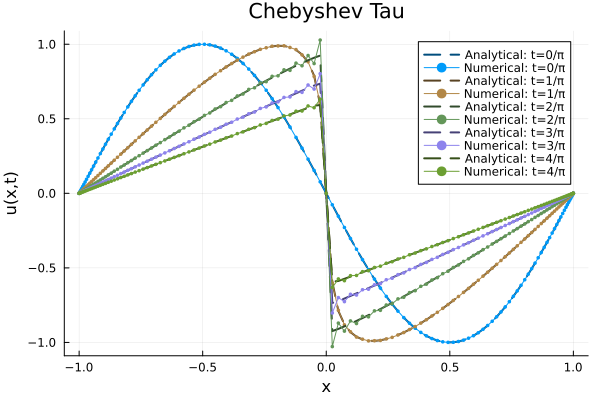

In [26]:
function plot_sol(method_name)
      plt = plot(title="$method_name", xlabel="x", ylabel="u(x,t)")
      pal = palette(:auto, length(snapshot_times))  # get default palette colors

      # Darken the analytical color by reducing brightness
      f = 0.5

      for (i, t) in enumerate(snapshot_times)
            num_color = pal[i]
            analytical_color = RGB(num_color.r * f, num_color.g * f, num_color.b * f)
            plot!(plt, x, analytical_solution(x, t), label="Analytical: t=$(i-1)/π", lw=2, linestyle=:dash, color=analytical_color)
            plot!(plt, x, snapshots[i], label="Numerical: t=$(i-1)/π", lw=1, color=num_color, marker=:circle, markersize=2, markerstrokewidth=0)
      end

      display(plt)
end

plot_sol("Chebyshev Tau")

Compared to the Fourier spectral method (both Galerkin and pseudospectral) for the same number of grid and time points, the Chebyshev-Tau method appears more accurate, with less oscillations in the solution.

#### Different grid spacings

A quick qualitative test of the effect of spatial and temporal grid spacings on the solution:

Solving: 100%[==========================================] Time: 0:00:00


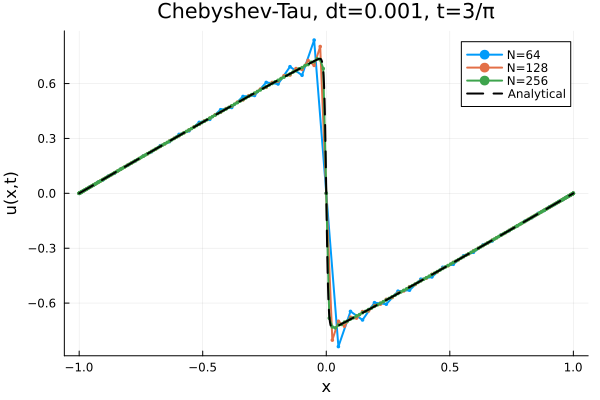

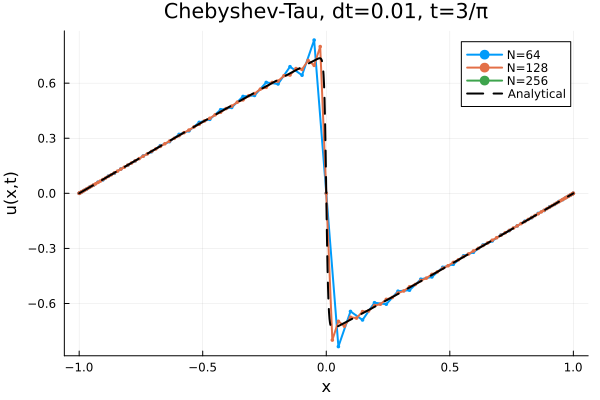

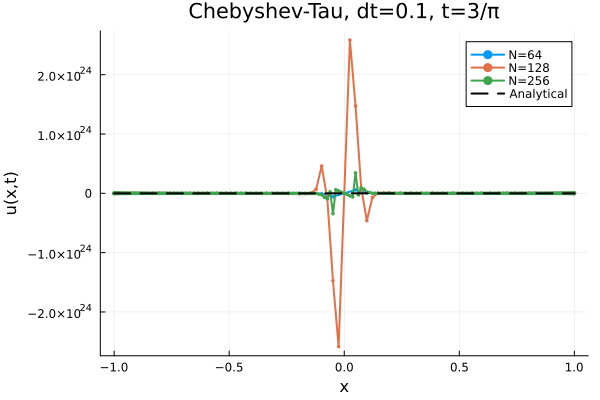

In [33]:
T = 3/pi
N_list = [64, 128, 256]
dt_list = [0.001, 0.01, 0.1]

for dt in dt_list
    plt = plot(title="Chebyshev-Tau, dt=$dt, t=3/π", xlabel="x", ylabel="u(x,t)")
    for N in N_list
        x, u_final, _, _ = solveChebyshevTau(N; dt=dt, T=T)
        plot!(plt, x, u_final, label="N=$N", lw=2, marker=:circle, markersize=2, markerstrokewidth=0)
    end
    x = range(-1, 1, length=1000)
    plot!(plt, x, analytical_solution(x, T), label="Analytical", lw=2, linestyle=:dash,color=:black)
    display(plt)
end

As for Fourier methods, we see that the solution for Chebyshev-Tau is more accurate for smaller spatial grid spacings (higher $N$) and that if the temporal grid spacing is too large, the solution becomes unstable and diverges.

Note that even more accuracy could be acheived with the same grid spacing by only considering half the domain and using the symmetry of the solution: Currently, most of the error is in the middle of the domain, where the gradient is the highest and our Chebyshev-Gauss-Lobatto grid points are most widely spaced. If the solved domain would instead end at the middle of the actual domain, the high-gradient region would be more densely covered by the Chebyshev-Gauss-Lobatto points, and the solution would be more accurate. They implement this in Basdevant1986, but I have not yet done so in my implementation.

# 4. Finite difference methods
This notebook demonstrates solving the 1D Burgers equation using finite differences with three-point backward differences (BDF2) and a non-uniform grid, more closely spaced around $x=0$.

We'll go over the following:
- How I apply a finite-difference method to the 1D Burgers equation
- Some example results from my implementation

A more thorough study of the performance is saved for the comparison between methods.


In [1]:
using Pkg
Pkg.activate("..") # activate BurgersJoint environment
Pkg.instantiate() # install all dependencies if necessary
using BurgersJoint
using BurgersJoint.BurgersEquation
using BurgersJoint.FiniteDifference
using Plots

  Activating project at `~/Documents/ACFPD/Individual assignment/BurgersJoint`
Precompiling project...
  14099.3 ms  ✓ BurgersJoint
  1 dependency successfully precompiled in 17 seconds. 621 already precompiled.


## Finite difference method applied to the 1D Burgers equation

In Basdevant1986, the description of their finite difference method essentially constitutes providing the below expression for the coordinate transformation and mentioning that a three-point backward scheme is used. They refer to a paper "Direct simulation of burgulence" by Orlandi and Briscolini (1983) for the details of the scheme. I have not been able to find this paper anywhere, so aside from the coordinate transformation, the rest of the implementation is based on my own understanding.

### Coordinate transformation

Like Basdevant1986, we will employ the following coordinate transformation to generate a grid that is more closely spaced in the high-gradient region around $x=0$:
$$
x = g(\zeta) = 
\begin{cases}
-1 + \frac{\tanh(2S \zeta)}{\tanh(S)},     & \text{for } \zeta \in [0,0.5[ \\
1 + \frac{\tanh(2S (\zeta-1))}{\tanh(S)},  & \text{for } \zeta \in [0.5,1]
\end{cases}
$$
with stretching parameter $S$. The values of $\zeta$ are evenly spaced between 0 and 1. When $S=0$, the $x$ grid is almost uniform. As $S$ increases, the grid becomes more concentrated around $x=0$ as the following figure illustrates:

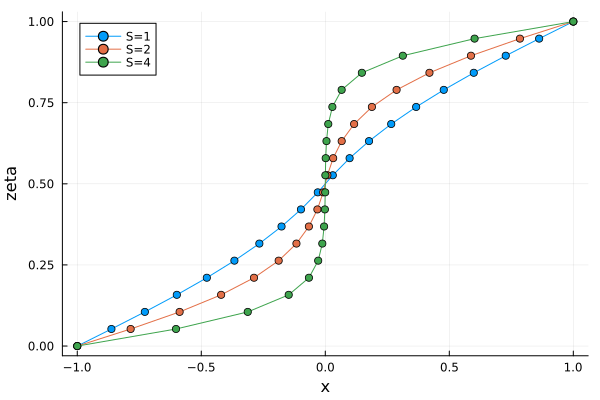

In [2]:
# Plot x vs zeta for different S values
N = 20
zeta = range(0.0, 1.0, length=N)
x = Array{Float64}(undef, N)
plt = plot()
for S in [1, 2, 4]
    for j in eachindex(zeta)
        if zeta[j] >= 0.5
            x[j] = 1 + tanh(2S*(zeta[j] - 1)) / tanh(S)
        else
            x[j] = -1 + tanh(2S*zeta[j]) / tanh(S)
        end
    end
    plot!(plt, x, zeta, label="S=$S", xlabel="x", ylabel="zeta", 
          marker=:circle, markersize=4, linewidth=1)
end
display(plt)


The transformation is continuous and differentiable. The Jacobian is given by
$$
\frac{\partial x}{\partial \zeta} = g'(\zeta) =
\begin{cases}
\frac{2S\ \text{sech}^2(2S \zeta)}{\tanh(S)},     & \text{for } \zeta \in [0,0.5[ \\
\frac{2S\ \text{sech}^2(2S (\zeta-1))}{\tanh(S)},  & \text{for } \zeta \in [0.5,1]
\end{cases}
$$
and the Hessian is given by
$$
\frac{\partial^2 x}{\partial \zeta^2} = g''(\zeta) =
\begin{cases}
-\frac{8S^2\ \text{sech}^2(2S \zeta) \tanh(2S \zeta)}{\tanh(S)},     & \text{for } \zeta \in [0,0.5[ \\
-\frac{8S^2\ \text{sech}^2(2S (\zeta-1)) \tanh(2S (\zeta-1))}{\tanh(S)},  & \text{for } \zeta \in [0.5,1]
\end{cases}.
$$

### Derivatives wrt. $x$ with finite differences

Using the chain rule, we can express the $x$ derivative of a function $u(x)$ in terms of the derivative with respect to $\zeta$:
$$
\frac{\partial u}{\partial x} = \frac{\partial \zeta}{\partial x} \frac{\partial u}{\partial \zeta} = \frac{1}{g'(\zeta)} \frac{\partial u}{\partial \zeta},
$$
which can be approximated by centered differences with uniform spacing $\Delta \zeta$:
$$
\frac{\partial u_i}{\partial x}=\frac{1}{g'_i} \frac{u_{i+1} - u_{i-1}}{2\Delta \zeta},
$$
For the second derivative wrt. $x$, we can use the chain rule again:
$$
\frac{\partial^2 u}{\partial x^2} 
= \frac{\partial}{\partial x}\left(\frac{\partial u}{\partial x}\right)
=  \frac{\partial\zeta}{\partial x} \frac{\partial}{\partial \zeta} \left(\frac{\partial u}{\partial x}\right) 
=  \frac{1}{g'(\zeta)} \frac{\partial}{\partial \zeta} \left(\frac{\partial u}{\partial x}\right) 
=   \frac{1}{g'(\zeta)} \frac{\partial}{\partial \zeta} \left(\frac{1}{g'(\zeta)} \frac{\partial u}{\partial \zeta}\right) 
$$
Using that
$$
\frac{\partial}{\partial \zeta}\left(\frac{1}{g'}\right) = - \frac{g''}{(g')^2},
$$
the product rule gives

$$
\frac{\partial^2 u}{\partial x^2} = \frac{1}{(g')^2} \frac{\partial^2 u}{\partial \zeta^2} - \frac{g''}{(g')^3} \frac{\partial u}{\partial \zeta} 
$$

Centered differences for the first and second derivatives wrt. $\zeta$ gives
$$
\frac{\partial u_i}{\partial \zeta} = \frac{u_{i+1} - u_{i-1}}{2\Delta \zeta}, \quad
\frac{\partial^2 u_i}{\partial \zeta^2} = \frac{u_{i+1} - 2u_i + u_{i-1}}{(\Delta \zeta)^2}
$$
Substituting these into the above expression gives
$$
\frac{\partial^2 u_i}{\partial x^2} = \frac{1}{(g_i')^2} \frac{u_{i+1} - 2u_i + u_{i-1}}{(\Delta \zeta)^2} - \frac{g_i''}{(g_i')^3} \frac{u_{i+1} - u_{i-1}}{2\Delta \zeta}
$$

I didn't have time to implement this expression, so for now I will use the following simpler expression for the second derivative:
$$
\frac{\partial^2 u_i}{\partial x^2} = \frac{2}{\Delta x_i + \Delta x_{i-1}} \left(\frac{u_{i+1} - u_i}{\Delta x_i} - \frac{u_i - u_{i-1}}{\Delta x_{i-1}}\right),
$$
where $\Delta x_i$ is simply found as the distance between neighboring grid points:
$$
\Delta x_i = \frac{x_{i+1} - x_i}{2}
$$

### Time discretization

I use two backward differentiation formulas (BDFs) to discretize the time derivative For bootstrapping, I apply the first-order BDF (BDF1) to Burgers' equation:
$$
\frac{u^1-u^0}{\Delta t}+u^0\left(\frac{\partial u^1}{\partial x}\right)=\nu \frac{\partial^2 u^1}{\partial x^2}
$$
where $u^n$ is the value of $u$ at time $t^n=n\Delta t$. Note here that the advection is linearized by using the value of $u$ at the previous time step $t^0$.

Given a known $u^0$ and the discretizations of the spatial derivatives, this can be written as a linear system of equations:
$$
\mathbf{b}(\mathbf{u}^0) = \mathbf{A} \mathbf{u}^1,
$$
where the exact expressions for $\mathbf{b}$ and $\mathbf{A}$ can be found in the implementation. As we used a three-point scheme for the spatial derivatives $\mathbf{A}$ is a tridiagonal matrix. The system can thus simply be solved by:
$$
\mathbf{u}^1 = \mathbf{A}^{-1} \mathbf{b}(\mathbf{u}^0),
$$
where $\mathbf{A}^{-1}$ can be computed using Thomas' algorithm.

For subsequent steps, I use the second-order BDF (BDF2) on Burgers' equation:
$$
\frac{3 u^n-4 u^{n-1}+u^{n-2}}{2 \Delta t}+u^{n-1}\left(\frac{\partial u^n}{\partial x}\right)=\nu \frac{\partial^2 u^{n}}{\partial x^2},
$$
where the advection term is now linearized using the value of $u$ at the previous time step $t^{n-1}$. This can be written as a linear system of equations:
$$
\mathbf{b}(\mathbf{u}^{n-1},\mathbf{u}^{n-2}) = \mathbf{A} \mathbf{u}^n,
$$
where expressions for $\mathbf{b}$ and $\mathbf{A}$ are different from BDF1 (see implementation) but still tridiagonal. The system can thus be solved in the same way as above:
$$
\mathbf{u}^n = \mathbf{A}^{-1} \mathbf{b}(\mathbf{u}^{n-1},\mathbf{u}^{n-2}),
$$

## Summary of the algorithm

1. Set up the grid using the coordinate transformation
2. Set up the tridiagonal matrix $\mathbf{A}$ and the right-hand side $\mathbf{b}$
3. Use BDF1 to compute $u^1$ from $u^0$
4. Time-stepping using BDF2 to compute $u^n$ from $u^{n-1}$ and $u^{n-2}$

## Example results
Let us look at a few example solutions using the Fourier spectral methods. We will use the following parameters unless otherwise specified:
- Domain $x\in[-1,1]$
- Viscosity $\nu = 10^{-2}/\pi$
- Initial condition $u(x,0) = -\sin(x)$
- Number of grid points - 1: $N = 32$
- Time step $\Delta t = 0.001$
- Total time $T = 4/\pi$

In [13]:
# Parameter choices:
N   = 32    # number of grid points
dt   = 1e-3
T = 4/pi    # final time
dt_snapshot = 1/pi

x, u_final, snapshot_times, snapshots = solveFiniteDifference(N;dt=dt, T=T, dt_snapshot=dt_snapshot)

([-1.0, -0.7473462250598857, -0.5249745313288203, -0.35020286807680323, -0.22466759325868457, -0.14021234100433766, -0.08586791653358117, -0.05189403922820368, -0.03103690880640575, -0.018374713838394507  …  0.018374713838394507, 0.03103690880640575, 0.05189403922820368, 0.08586791653358117, 0.14021234100433777, 0.22466759325868457, 0.3502028680768031, 0.5249745313288201, 0.7473462250598859, 1.0], [0.0, 0.16260138092082344, 0.30329618082162724, 0.41107868304972983, 0.4862625441731141, 0.5355219667251002, 0.5672818349256493, 0.5857727259727405, 0.5999153451625446, 0.5885595304216262  …  -0.588559530421636, -0.5999153451625461, -0.5857727259727439, -0.5672818349256532, -0.535521966725102, -0.48626254417311676, -0.4110786830497313, -0.30329618082162607, -0.1626013809208247, 0.0], [0.0, 0.318, 0.637, 0.9550000000000001, 1.2730000000000001], [[0.0, 0.7129773443374345, 0.9969236082261097, 0.8912956844582021, 0.6486536126092263, 0.426382796901451, 0.26650206685424854, 0.16230870266477948, 0.0

Plot numerical solution versus analytical solution at different times:

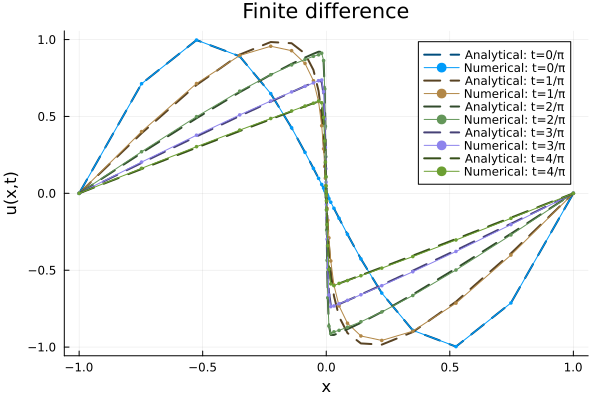

In [14]:
function plot_sol(method_name)
    plt = plot(title="$method_name", xlabel="x", ylabel="u(x,t)")
    pal = palette(:auto, length(snapshot_times))  # get default palette colors

    # Darken the analytical color by reducing brightness
    f = 0.5

    for (i, t) in enumerate(snapshot_times)
          num_color = pal[i]
          analytical_color = RGB(num_color.r * f, num_color.g * f, num_color.b * f)
          plot!(plt, x, analytical_solution(x, t), label="Analytical: t=$(i-1)/π", lw=2, linestyle=:dash, color=analytical_color)
          plot!(plt, x, snapshots[i], label="Numerical: t=$(i-1)/π", lw=1, color=num_color, marker=:circle, markersize=2, markerstrokewidth=0)
    end

    display(plt)
end

plot_sol("Finite difference")

We see that even with a relatively coarse grid, the solution is very close to the analytical solution. This is probably in part due to the coordinate transformation concentrating grid-points around the high-gradient region. The numerical solution appears slightly more diffusive than the analytical solution. That could be due to the finite difference scheme or the coordinate transformation, but would require further investigation to determine.

#### Different grid spacings

A quick qualitative test of the effect of spatial and temporal grid spacings on the solution:

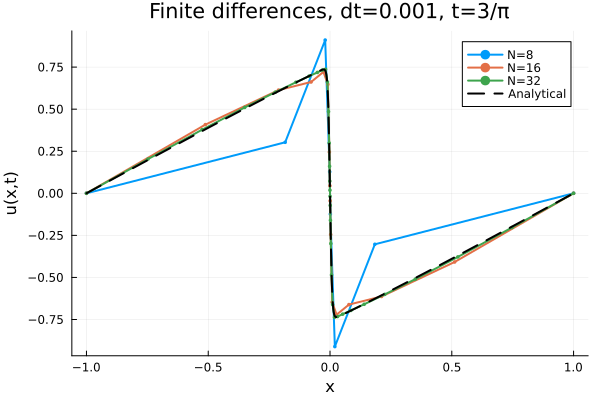

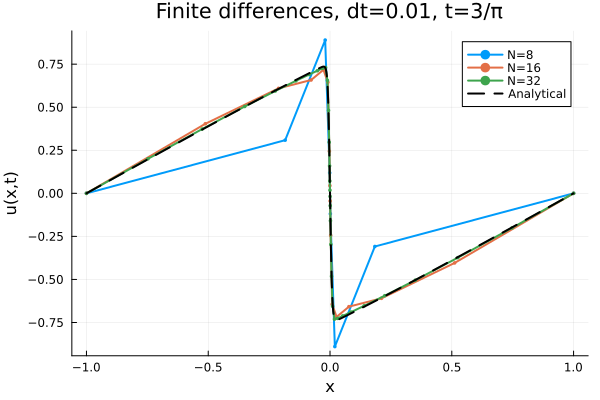

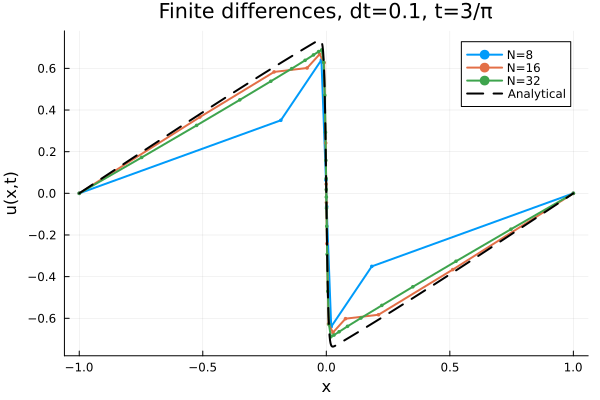

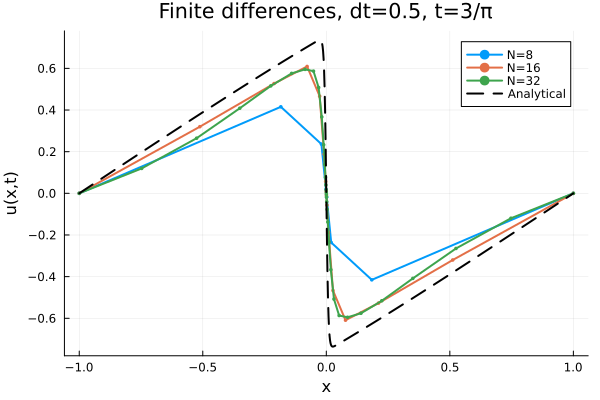

In [24]:
T = 3/pi
N_list = [8, 16, 32]
dt_list = [0.001, 0.01, 0.1, 0.5]

for dt in dt_list
    plt = plot(title="Finite differences, dt=$dt, t=3/π", xlabel="x", ylabel="u(x,t)")
    for N in N_list
        x, u_final, _, _ = solveFiniteDifference(N; dt=dt, T=T)
        plot!(plt, x, u_final, label="N=$N", lw=2, marker=:circle, markersize=2, markerstrokewidth=0)
    end
    x = range(-1, 1, length=1000)
    plot!(plt, x, analytical_solution(x, T), label="Analytical", lw=2, linestyle=:dash,color=:black)
    display(plt)
end

Compared to Fourier and Chebyshev methods studied previously, we see that it takes extremely coarse spatial grids to start to lose accuracy. It could be that the coordinate transformation is helping with this, which would have to be investigated further. The BDF2 method is implicit and therefore likely more stable than the explicit methods used previously.

# 2. Neural network
This notebook demonstrates solving the 1D Burgers Equation using a physics-informed neural network (PINNs).


We'll go over the following:
- How I apply the PINN method to solve the 1D Burgers equation
- Some example results from my implementation

A more thorough study of the performance is saved for the comparison between methods.


In [1]:
using Pkg
Pkg.activate("..") # activate BurgersJoint environment
Pkg.instantiate() # install all dependencies if necessary
using BurgersJoint
using BurgersJoint.BurgersEquation
using BurgersJoint.NeuralNetwork
using Plots

  Activating project at `~/Documents/ACFPD/Individual assignment/BurgersJoint`


## Physics-informed neural networks (PINNs) for the 1D Burgers equation

A physics-informed neural network (PINN) is a type of neural network that incorporates physical laws into its training process. This allows the network to learn not only from data but also from the underlying physics governing the problem (i.e. the governing equations). PINNs are particularly useful for solving partial differential equations (PDEs) such as the Burgers equation.

The following assumes that the reader is already familiar with neural networks. We will employ a multilayer perceptron (MLP) architecture with four fully connected layers. The architecture is as follows:
1. Input layer: 2 inputs (x, t), 16 neurons, sigmoid activation function
2. Hidden layer: 16 neurons, sigmoid activation function
3. Hidden layer: 16 neurons, sigmoid activation function
4. Output layer: 1 output (u), no activation function

Note that I initially also wanted to implement a Kolmogorov-Arnold network (KAN) and compare it to MLPs, but I didn't have time to play with this yet.

I choose to use simple grid training with spatial step $\Delta x = 2(N-1)$ and temporal step $\Delta t$, where $N$ is the number of grid points. The spatial grid is uniformly distributed in the domain $[-1, 1]$ whereas the temporal grid is uniformly distributed in the domain $[0, T]$. I chose this as it trains faster on CPU than more robust strategies like stochastic, quasi-random, or quadrature sampling, as I haven't managed to get GPU acceleration working yet (I blame Linux drivers).

I use the following loss functions for training:
- PDE loss: Represents the residuals of the PDEs at specified collocation points. This is done by applying the differential operators of the PDE system to the neural network's trial solution and penalizing deviations by the mean squared error (MSE).
- BC loss: MSE between the trial solution and the boundary conditions at the specified collocation points (includes actualy BCs, but also initial conditions and potentially other constraints on values of $u$ such as symmetry).

So no information about the solution

Reverse-mode automatic differentiation (AD) is used to calculate gradients of the loss functions with respect to the neural network parameters. The Broyden-Fletcher-Goldfarb-Shanno algorithm (BFGS) is used to optimize the loss function based on the gradients with a maximum of 3000 iterations.

## Example results
Let us look at a few example solutions using the Fourier spectral methods. We will use the following parameters unless otherwise specified:
- Domain $x\in[-1,1]$
- Viscosity $\nu = 10^{-2}/\pi$
- Initial condition $u(x,0) = -\sin(x)$
- Number of grid points $N = 32$
- Time step $\Delta t = 0.01$ (only used for grid training)
- Total time $T = 4/\pi$

Training PINN 100%|██████████████████████████████████████| Time: 0:06:04:49


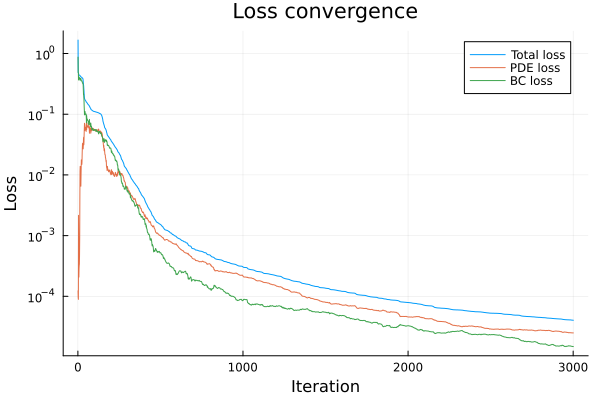

[ Info: Using existing trained model.


(-1.0:0.06451612903225806:1.0, [-0.0006613863993767399, 0.04073005040334543, 0.08180090255371009, 0.12253311922129573, 0.16292964218083372, 0.2030151014060193, 0.24284230751735358, 0.2825009182092757, 0.32212379104379496, 0.36187961147930503  …  -0.363200930574028, -0.3234682612938926, -0.28336874024077674, -0.2429364320413907, -0.20226442160204305, -0.16148852667013602, -0.12077160551826349, -0.08028820470090925, -0.04020839501417783, -0.0006796220896283511], 0.0:0.3183098861837907:1.2732395447351628, [[0.0004908091552919824, 0.20612094889415, 0.39553742490392896, 0.5682658188199371, 0.7210537203479339, 0.8477563730931585, 0.9403994974440105, 0.9920089303088635, 0.999746904914399, 0.965245834819094  …  -0.9656221190143954, -1.001451548734173, -0.9925552184184436, -0.9390737315899753, -0.8465440073561523, -0.72166373198064, -0.5700646563369163, -0.39614448654244594, -0.20411751181802162, 0.0003138680510121894], [-0.0006668823789097722, 0.10274748326154137, 0.20420835636403334, 0.303482

In [ ]:
# Parameter choices:
N   = 32    # number of grid points
dt   = 1e-2   # time step
T = 4/pi    # final time
dt_snapshot = 1/pi # time between solution snapshots
# with these settings, training takes ~ 5 min on my laptop

trainNeuralNetwork(N; T=T, dt=dt)

It seems that 3000 iterations is not enough to fully converge to a solution, but the results are still within $\sim 10^{-4}$ of the true solution on the considered grid. 

We now look at the numerical solution versus analytical solution at different times:

[ Info: Using existing trained model.


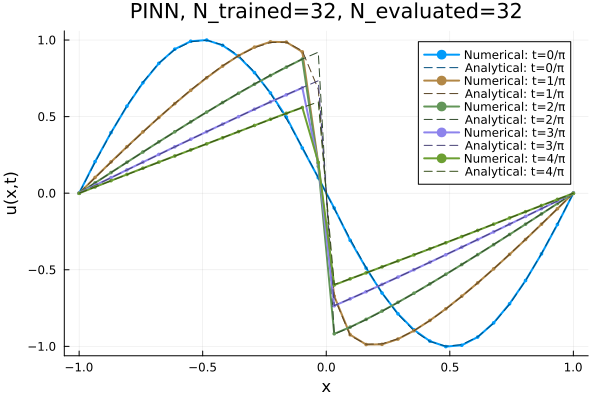

In [22]:
x, u_final, snapshot_times, snapshots = solveNeuralNetwork(N; dt=dt, T=T, dt_snapshot=dt_snapshot)

function plot_sol(method_name)
      plt = plot(title="$method_name", xlabel="x", ylabel="u(x,t)")
      pal = palette(:auto, length(snapshot_times))  # get default palette colors

      # Darken the analytical color by reducing brightness
      f = 0.5

      for (i, t) in enumerate(snapshot_times)
            num_color = pal[i]
            analytical_color = RGB(num_color.r * f, num_color.g * f, num_color.b * f)
            plot!(plt, x, snapshots[i], label="Numerical: t=$(i-1)/π", lw=2, color=num_color, marker=:circle, markersize=2, markerstrokewidth=0)
            plot!(plt, x, analytical_solution(x, t), label="Analytical: t=$(i-1)/π", lw=1, linestyle=:dash, color=analytical_color)
      end

      display(plt)
end

plot_sol("PINN, N_trained=32, N_evaluated=32")

This looks very close to the analytical solution, especially compared to the other methods with similar grid spacing. The solution appears to deviate at the grid point just at the left of $x=0$. This is probably due to the gradient of the solution being the highest around there. The solution here could probably be improved with a more robust training strategy (e.g. stochastic sampling).

If we use the same trained model (trained with grid spacing $N=32$), but evaluate it on a grid with $N=64$, we get:

[ Info: Using existing trained model.


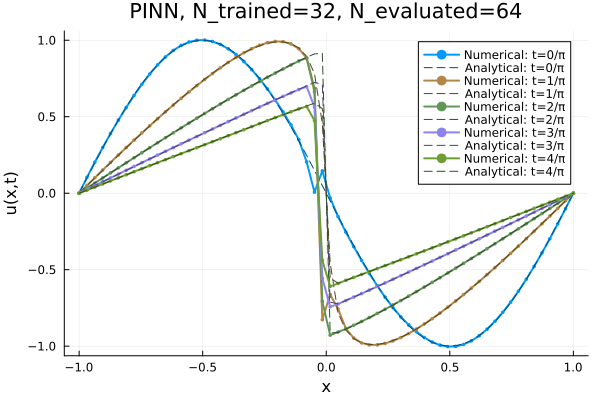

In [21]:
x, u_final, snapshot_times, snapshots = solveNeuralNetwork(64; dt=dt, T=T, dt_snapshot=dt_snapshot)
plot_sol("PINN, N_trained=32, N_evaluated=64")

It seems it is possible to generalize the model to a finer grid spacing with similar error (qualitatively), indicating overfitting is not a major problem. Again, deviations are seen around the center of the domain, even at $t=0$, where the solution should be smooth. 

# 6. Comparison of methods

In this section, we will compare the performance of the different methods we have implemented so far:
- Fourier Galerkin spectral method
- Chebyshev-Tau spectral method
- BDF2 finite difference method with coordinate transformation
- Physics-informed neural network (PINN) method

First we import all the modules:

In [1]:
using Pkg
Pkg.activate("..") # activate BurgersJoint environment
Pkg.instantiate() # install all dependencies if necessary
using BurgersJoint
using BurgersJoint.BurgersEquation
using BurgersJoint.FourierSpectral
using BurgersJoint.ChebyshevTau
using BurgersJoint.FiniteDifference
using BurgersJoint.NeuralNetwork
using Plots
using Statistics

  Activating project at `~/Documents/ACFPD/Individual assignment/BurgersJoint`


## Study of error convergence

In the interest of time, we will just look at how the error (RMSE) wrt. the analytical solution behaves with the spatial and temporal discretization for the Fourier Galerkin, Chebyshev-Tau, and finite difference methods. The PINN method is not included ,in this study, as it would require a lot of time to train the neural network for each spacing. And in real-life scenarios, grid training would not be used, so the idea of having a discrete grid is not relevant for PINNs.

The study will be conducted for the default parameters of the problem and the solvers unless otherwise stated. 

The study uses a final time of $T=3/\pi$.

In [79]:
solvers = [solveFourierSpectral, solveChebyshevTau, solveFiniteDifference]

T = 3/pi
N_list = [16, 32, 64, 128, 256, 512, 1024] # Number of grid points
dt_list = [0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001] # Time step sizes

RMSE_list = zeros(length(solvers), length(N_list), length(dt_list))

# Loop over solvers
for (i, solver) in enumerate(solvers)
    println("Solver: ", solver)
    # Loop over N
    for (j, N) in enumerate(N_list)
        # Loop over dt
        for (k, dt) in enumerate(dt_list)
            x, u_num, _, _  = solver(N; dt=dt, T=T) # Numerical solution
            u_ana = analytical_solution(x, T;n=100) # Analytical solution, we use quadrature with n=100 nodes for an accurate solution (not sure how many digits though)
            RMSE_list[i, j, k] = sqrt(mean((u_num - u_ana).^2)) # RMSE
        end
    end
end


Solving: 100%[==========================================] Time: 0:00:01
Solving: 100%[==========================================] Time: 0:00:00
Solving: 100%[==========================================] Time: 0:00:01
Solving: 100%[==========================================] Time: 0:00:05
Solving: 100%[==========================================] Time: 0:00:00
Solving: 100%[==========================================] Time: 0:00:02
Solving: 100%[==========================================] Time: 0:00:05
Solving: 100%[==========================================] Time: 0:00:26
Solving: 100%[==========================================] Time: 0:00:00
Solving: 100%[==========================================] Time: 0:00:01
Solving: 100%[==========================================] Time: 0:00:02
Solving: 100%[==========================================] Time: 0:00:11
Solving: 100%[==========================================] Time: 0:00:23
Solving: 100%[==========================================] Time: 

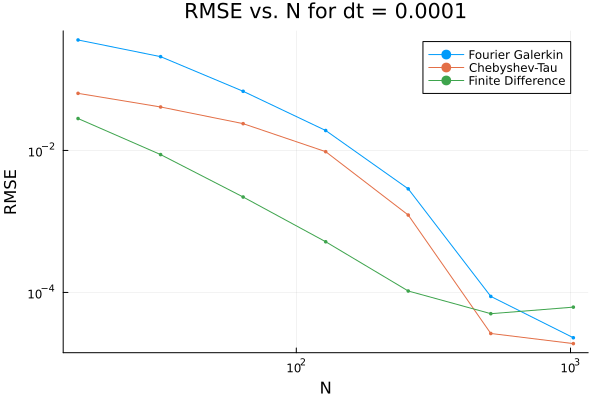

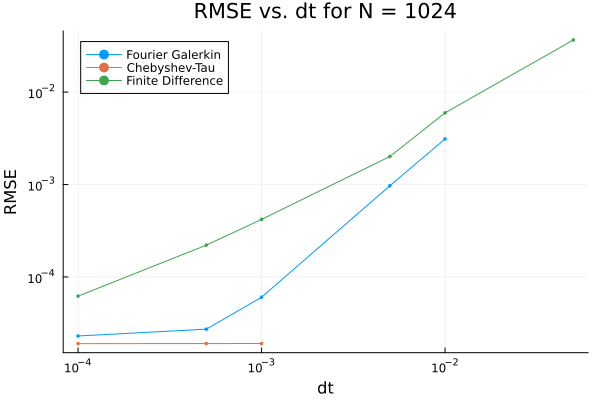

In [80]:
# Plotting
labels = ["Fourier Galerkin", "Chebyshev-Tau", "Finite Difference"]

# RMSE vs. N for each solver at smallest dt
dt_end = dt_list[end]
plt = plot(title="RMSE vs. N for dt = $dt_end", xlabel="N", ylabel="RMSE", yscale=:log, xscale=:log)
for (i, solver) in enumerate(solvers)
    plot!(plt, N_list, RMSE_list[i, :, end], label=labels[i], marker=:circle, markersize=2, markerstrokewidth=0)
end
display(plt)

# RMSE vs. dt for each solver at largest N
N_end = N_list[end]
plt = plot(title="RMSE vs. dt for N = $N_end", xlabel="dt", ylabel="RMSE", yscale=:log, xscale=:log)
for (i, solver) in enumerate(solvers)
    plot!(plt, dt_list, RMSE_list[i, end, :], label=labels[i], marker=:circle, markersize=2, markerstrokewidth=0)
end
display(plt)



**Spatial convergence:**

Considering the plot of RMSE vs. N we see that both Fourier Galerkin and Chebyshev-Tau methods show exponential (spectral) convergence as expected of spectral methods, with the Chebyshev-Tau method converging faster than the Fourier Galerkin method. The finite difference method shows polynomial convergence, which is expected as it is a second-order method in space (using a three-point stencil). For low $N$, the finite difference method has lowest error, but as $N$ increases, the spectral methods outperform it due to spectral convergence.

**Temporal convergence:**
Considering the plot of RMSE vs. dt we first notice that for fine timesteps, Chebyshev-Tau has the lowest error, followed by Fourier Galerkin method, and then finite difference, given same number of spatial points. However, for $\Delta t>10^{-3}$, the Chebyshev-Tau method diverges. Perhaps solving the half-domain so the collocation points would be more concentrated around the high-gradient region would improve stability of Chebyshev-Tau. Only the finite difference method is stable for all $\Delta t$ considered, probably because it uses an implicit method for time-integration (BDF2). For both Fourier Galerkin and finite difference methods, the error appears to be polynomial in $\Delta t$. We expect the error to be second-order in $\Delta t$ for both methods, as both methods use a second-order method in time, the leapfrog-like scheme and BDF2, respectively for Fourier and finite difference.

### Study of convergence order

We first study the spatial convergence of the finite difference method (the others were exponentially convergent):

Estimated convergence order: -2.017497265610892


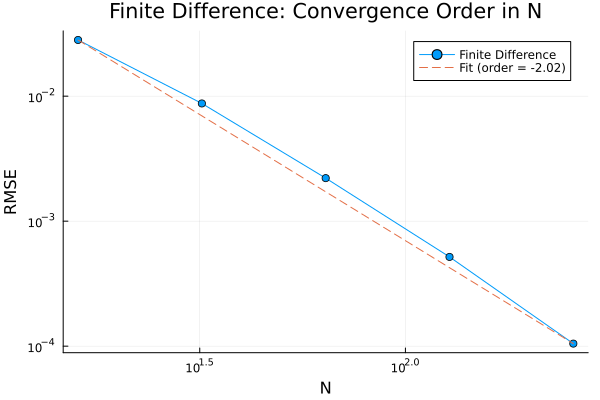

In [82]:
# Convergence order in N for finite difference for the last dt
i = 3 # Finite difference
solver = solvers[i]
label = labels[i]
N_list_conv = N_list[1:end-2] # Exclude the last N for convergence order
rmse_fd = RMSE_list[i, 1:length(N_list_conv), end]
orders = diff(log10.(rmse_fd)) ./ diff(log10.(N_list_conv))
mean_order = mean(orders)
c = rmse_fd[1] / N_list_conv[1]^mean_order
fitted_line = c .* (N_list_conv .^ mean_order)
println("Estimated convergence order: ", mean_order)

plt_fd = plot(N_list_conv, rmse_fd, marker=:circle, xlabel="N", ylabel="RMSE",
              xscale=:log10, yscale=:log10, label=label,
              title="Finite Difference: Convergence Order in N")
plot!(N_list_conv, fitted_line, linestyle=:dash,
      label="Fit (order = $(round(mean_order, digits=2)))")
display(plt_fd)

This is almost exactly $O(N^{-2})$ convergence, as expected from the second-order discretization of the spatial derivatives used in the method.

We now study the temporal convergence of the Fourier Galerkin and the finite difference methods:

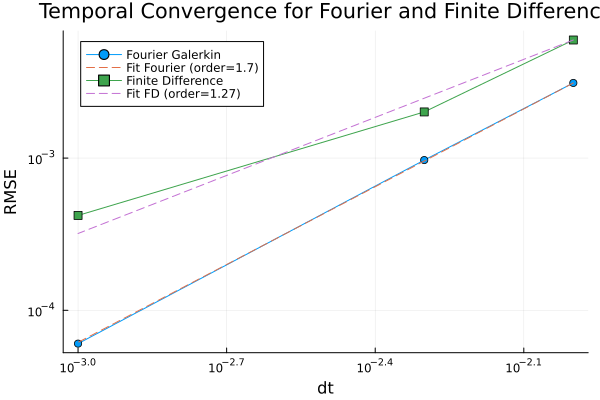

In [ ]:
# Convergence order in dt for Fourier and finite difference for the last N
idx_range = 2:4 # Index range for power-law like region
dt_list_conv = dt_list[idx_range] 

# For Fourier Spectral method (index 1)
rmse_fourier = RMSE_list[1, end, idx_range]
orders_fourier = diff(log10.(rmse_fourier)) ./ diff(log10.(dt_list_conv))
mean_order_fourier = mean(orders_fourier)
c_fourier = rmse_fourier[1] / dt_list_conv[1]^mean_order_fourier
fitted_fourier = c_fourier .* (dt_list_conv .^ mean_order_fourier)

# For Finite Difference method (index 3)
rmse_fd_dt = RMSE_list[3, end, idx_range]
orders_fd = diff(log10.(rmse_fd_dt)) ./ diff(log10.(dt_list_conv))
mean_order_fd = mean(orders_fd)
c_fd = rmse_fd_dt[1] / dt_list_conv[1]^mean_order_fd
fitted_fd = c_fd .* (dt_list_conv .^ mean_order_fd)

# Plotting both temporal convergence curves and their fitted lines
plt_dt = plot(dt_list_conv, rmse_fourier, marker=:circle, xlabel="dt", ylabel="RMSE",
              xscale=:log10, yscale=:log10, label=labels[1],
              title="Temporal Convergence for Fourier and Finite Difference")
plot!(dt_list_conv, fitted_fourier, linestyle=:dash,
      label="Fit Fourier (order=$(round(mean_order_fourier, digits=2)))")
plot!(dt_list_conv, rmse_fd_dt, marker=:square, label=labels[3])
plot!(dt_list_conv, fitted_fd, linestyle=:dash,
      label="Fit FD (order=$(round(mean_order_fd, digits=2)))")
display(plt_dt)

As stated earlier, we expect the error to be second-order in $\Delta t$ for both methods, as both methods use a second-order method for time integration. The results are not quite the expected $O(\Delta t^2)$ however, but seemingly $O(\Delta t^{1.7})$ for Fourier and $O(\Delta t^{1.3})$ for finite difference. This could be due to spatial discretization errors or that the solution is not smooth enough in time. 